In [109]:
import numpy as np
import  torch
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torch import nn
import torch.optim as optim
import math

In [110]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [111]:
class VGG_vision(nn.Module):
    def __init__(self,in_channel=3,num_classes=10, stride=1,channel_factor=0.65, kernel_factor=1.25):
        super(VGG_vision,self).__init__()
        self.in_channel = in_channel
        self.channel_fctor = channel_factor
        self.kernel_factor = kernel_factor

        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channel,128,kernel_size=1, stride=stride, padding=0),
            nn.Conv2d(128,128,kernel_size=1, stride=stride, padding=0),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        in_channel = 128
        out_channel = math.ceil(in_channel*channel_factor)
        temp = kernel_factor
        kernels = math.ceil(temp)
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.Conv2d(out_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        in_channel = out_channel
        out_channel = math.ceil(in_channel*channel_factor)
        temp = temp * kernel_factor
        kernels = math.ceil(temp)
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.Conv2d(out_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.Conv2d(out_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        in_channel = out_channel
        out_channel = math.ceil(in_channel*channel_factor)
        temp = temp * kernel_factor
        kernels = math.ceil(temp)
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.Conv2d(out_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.Conv2d(out_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        in_channel = out_channel
        out_channel = math.ceil(in_channel*channel_factor)
        temp = temp * kernel_factor
        kernels = math.ceil(temp)
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.Conv2d(out_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.Conv2d(out_channel,out_channel,kernel_size=kernels, stride=stride, padding=1),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.dense = nn.Sequential(
            nn.Linear(out_channel*4, 4096),
            nn.Linear(4096, 4096),
            nn.Linear(4096, num_classes)
        )
    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        x = x.view(x.size(0),-1)
        x = self.dense(x)
        return x
    

In [112]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Files already downloaded and verified
Files already downloaded and verified


In [113]:
def train2d(model, train_loader, loss_func, optimizer):
    batch_loss = 0.0
    correct = 0
    total = 0
    model.train()  # Set the model to training mode
    for data in train_loader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_func(outputs, labels)
        loss.backward()
        optimizer.step()

        batch_loss += loss.item()
        _, predicted_indices = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted_indices == labels).sum().item()

    epoch_loss = batch_loss / len(train_loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def validate2d(model, loader, loss_func):
    model.eval()  # Set the model to evaluation mode
    batch_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to GPU
            outputs = model(inputs)
            loss = loss_func(outputs, labels)
            batch_loss += loss.item() * inputs.size(0)
            _, predicted_indices = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted_indices == labels).sum().item()

    epoch_loss = batch_loss / len(loader.dataset)
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [114]:
test_loader = DataLoader(test_data, batch_size=128, shuffle=False)

num_epochs = 25
train_losses, train_accuracies = [], []
val_losses, val_accuracies = [], []

model_2d = VGG_vision().to(device=device)
loss_func2d = nn.CrossEntropyLoss()
optimizer2d = optim.Adam(model_2d.parameters(), lr=0.0003)

# Training and validation loops
for epoch in range(num_epochs):
    train_loader = DataLoader(training_data, batch_size=128, shuffle=True)
    train_loss, train_acc = train2d(model_2d, train_loader, loss_func2d, optimizer2d)
    val_loss, val_acc = validate2d(model_2d, test_loader, loss_func2d)

    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')


Epoch 1/25, Train Loss: 0.0152, Train Acc: 0.2734, Val Loss: 1.6187, Val Acc: 0.4142
Epoch 2/25, Train Loss: 0.0118, Train Acc: 0.4491, Val Loss: 1.4315, Val Acc: 0.4764
Epoch 3/25, Train Loss: 0.0104, Train Acc: 0.5233, Val Loss: 1.3194, Val Acc: 0.5256
Epoch 4/25, Train Loss: 0.0094, Train Acc: 0.5675, Val Loss: 1.1924, Val Acc: 0.5679
Epoch 5/25, Train Loss: 0.0088, Train Acc: 0.5997, Val Loss: 1.1454, Val Acc: 0.5860
Epoch 6/25, Train Loss: 0.0083, Train Acc: 0.6225, Val Loss: 1.1195, Val Acc: 0.6062
Epoch 7/25, Train Loss: 0.0078, Train Acc: 0.6415, Val Loss: 1.0584, Val Acc: 0.6254
Epoch 8/25, Train Loss: 0.0075, Train Acc: 0.6570, Val Loss: 1.0428, Val Acc: 0.6303
Epoch 9/25, Train Loss: 0.0072, Train Acc: 0.6735, Val Loss: 1.0140, Val Acc: 0.6458
Epoch 10/25, Train Loss: 0.0069, Train Acc: 0.6864, Val Loss: 0.9940, Val Acc: 0.6526
Epoch 11/25, Train Loss: 0.0067, Train Acc: 0.6970, Val Loss: 0.9777, Val Acc: 0.6545
Epoch 12/25, Train Loss: 0.0064, Train Acc: 0.7082, Val Loss: 0

In [115]:
#Saving model parameters
torch.save(model_2d.state_dict(), 'VGG_vision.pt')

In [116]:
#Loading the trained model parameters
model = VGG_vision()
model.load_state_dict(torch.load('VGG_vision.pt'))

<All keys matched successfully>

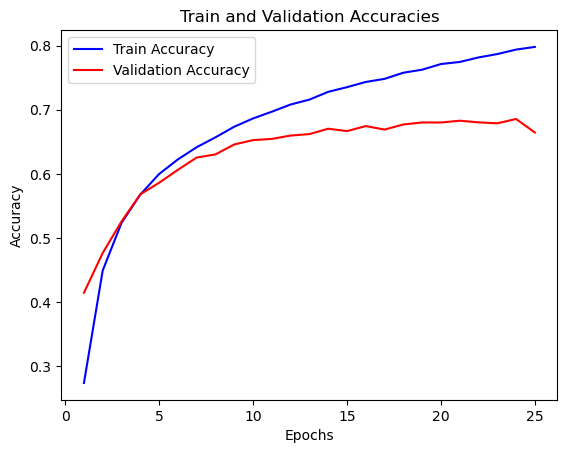

In [117]:
epochs = range(1, num_epochs + 1)
plt.plot(epochs, train_accuracies, 'b', label='Train Accuracy')
plt.plot(epochs, val_accuracies, 'r', label='Validation Accuracy')
plt.title('Train and Validation Accuracies')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()